### Submission Instructions

Just fill in the cells below with the markdown notes and your code and add any extra cells with the code or comments you see fit, **giving a proper structure to your final notebook**.

When you think everything is finished and before your submission, make sure the notebook works fine by executing `Kernel/Restart & Run All`.
  
Once the notebook is ready,
1. Create a folder named `pNN` with the team's number.

2. Put in that folder:

* a file `pNN.ipynb` with the cells below completed. Make sure it works by executing Kernel/Restart & Run All.
* a file `pNN.html` with an html rendering of the previous .ipynb file (just apply File / Download as HTML after a correct run of Kernel/Restart & Run All).

3. Compress the folder to a `pNN.7z` 7z (or zip) file.

**Very important!!!**

Make sure you follow the file naming conventions above; the miniproject won't be graded until that is so.

## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

**Make sure the cells above do not appear in the nootebookyou submit**

# Wind Energy Prediction

The aim of this problem is to predict the hourly wind power generation for a wind farm.

Attribute Information:

Data for two years are given in two csv files with a first column with a datetime and the rest with headers

`['10u', '10v', '2t', 'sp', '100u', '100v', 'vel10', 'vel100', 'targ']`


where

* `targ` is the wind energy production normalized to a [0., 1.] range.
* `10u,10v, 100u, 100v` are the U (west-east) and V (south-north) wind components in m/s at heights 10 m and 100 m.
* `vel10,vel100` are the absolute wind speeds in m/s at heights 10 and 100 meters.
* `2t,sp` are surface temperature and pressure.

In order to simplify our computations, we are going to drop the `10, 10v, vel10` columns, but add three new variables:

* the sine and cosine of the wind at 100 meters.
* the cube of the `vel100` variable, as theoretically the energy of the wind that hits the blades is proportional to the cube of wind speed.

Thus our final eight variables must be:

* `100u, 100v`, the U (west-east) and V (south-north) wind components in m/s at height 100 m.
* `vel100`, the absolute wind speeds in m/s at height 100 meters.
* `vel100_3`, the cube of `vel100`.
* `s100, c100`, the sine and cosine of the wind direction at height 100 meters.
* `2t,sp`, surface temperature and pressure.

We are going to work with data fromn the years 2016, 2017 and 2018. Years 2016 and 2017 will be used for train and validation, and the year 2018 for test.

In [1]:
%matplotlib inline

In [2]:
import time

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

ModuleNotFoundError: No module named 'seaborn'

## Data Loading

Leer los datos 

In [5]:
data_dir = 'C:/INFINET/DOCUMENTOS/PERSONAL/UAM/'

data_dir = 'C:/INFINET/DOCUMENTOS/PERSONAL/UAM/'

d_years = {}
for yy in ['2016', '2017', '2018']:
    f_name = 'df_' + yy + '.csv'
    print(f_name)
    d_years[yy] = pd.read_csv(data_dir + f_name, sep=',', parse_dates=True, index_col=0)

df_2016.csv
df_2017.csv
df_2018.csv


Eliminar y añadir nuevas variables

In [ ]:
# Eliminar columnas sobrantes

df16 = pd.DataFrame(d_years['2016'])

df16 = df16.drop(columns=['10u','10v','vel10'])

# Calcular dirección del viento a partir de sus componentes U y V (en radianes).
# Dirección = arct(u/v) + alfa ; donde alfa = 180 si v>0, alfa = 0 si u<0 y v<0, y alfa=360 si u>0 y v<0.
# (usando arctan2 no es necesario ajustar)

dir_viento = np.arctan2(df16['100u'],df16['100v'])

# Transformamos de Radianes a Grados

dir_viento = np.degrees(dir_viento)


s100 = np.sin (dir_viento)
c100 = np.cos (dir_viento)
vel100_3 = df16['vel100'] * df16['vel100'] * df16['vel100']

# Insertar nuevas columnas

df16.insert(6,'s100',s100)
df16.insert(7,'c100',c100)
df16.insert(8,'vel100_3',vel100_3)
df16.insert(9,'dir_viento', dir_viento)


print(df16)




                             2t          sp      100u       100v     vel100  \
prediction date                                                               
2016-01-01 00:00:00  280.243408  96301.0625 -1.704901   9.569272   9.719962   
2016-01-01 01:00:00  280.878174  96235.6875 -1.308282   9.653047   9.741299   
2016-01-01 02:00:00  280.855469  96137.6875 -1.604064   9.973378  10.101549   
2016-01-01 03:00:00  280.964600  96046.0000 -1.904279  10.185605  10.362086   
2016-01-01 04:00:00  281.088379  95899.0625 -2.028903  10.770628  10.960058   
...                         ...         ...       ...        ...        ...   
2016-12-31 19:00:00  279.416260  96852.7500 -0.053548   0.839069   0.840776   
2016-12-31 20:00:00  279.188232  96859.3125  0.512859   0.984722   1.110271   
2016-12-31 21:00:00  277.172607  96854.3125  0.757543   0.981745   1.240038   
2016-12-31 22:00:00  275.066895  96844.6875  0.557252   1.446654   1.550270   
2016-12-31 23:00:00  274.541748  96818.0000  0.71653

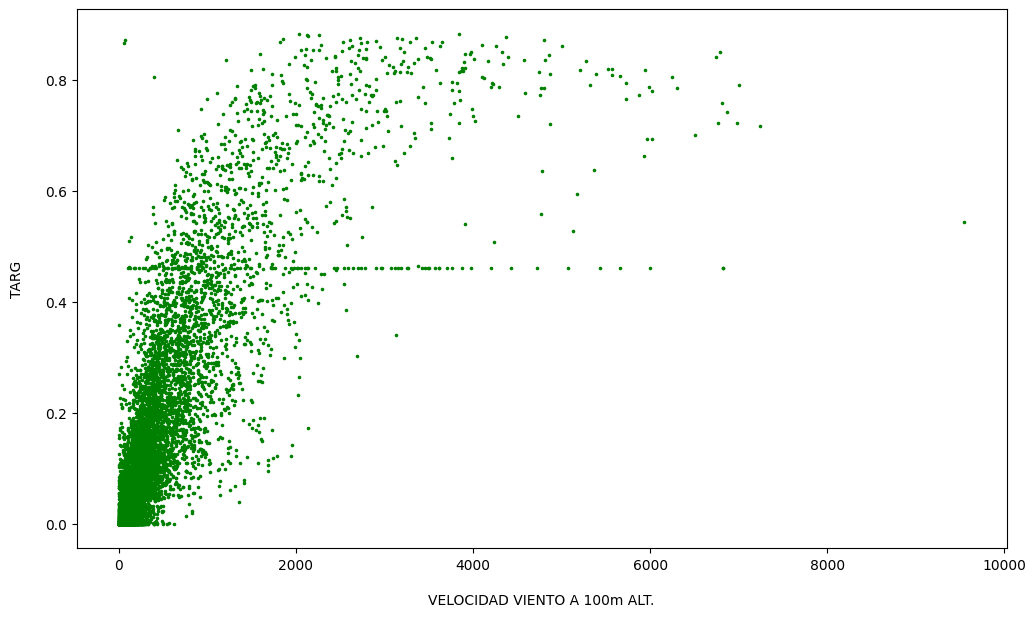

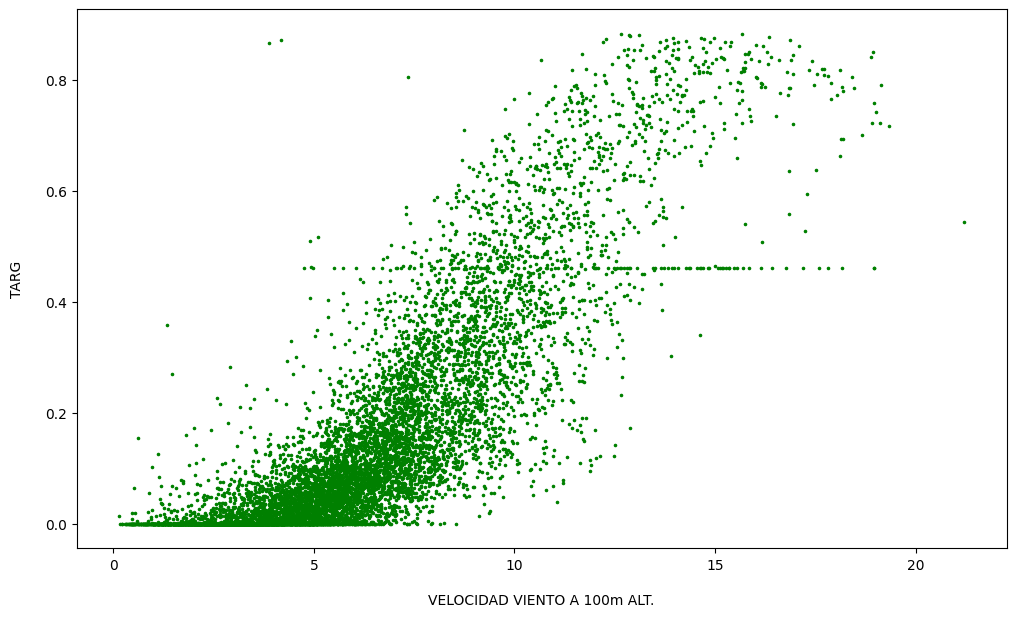

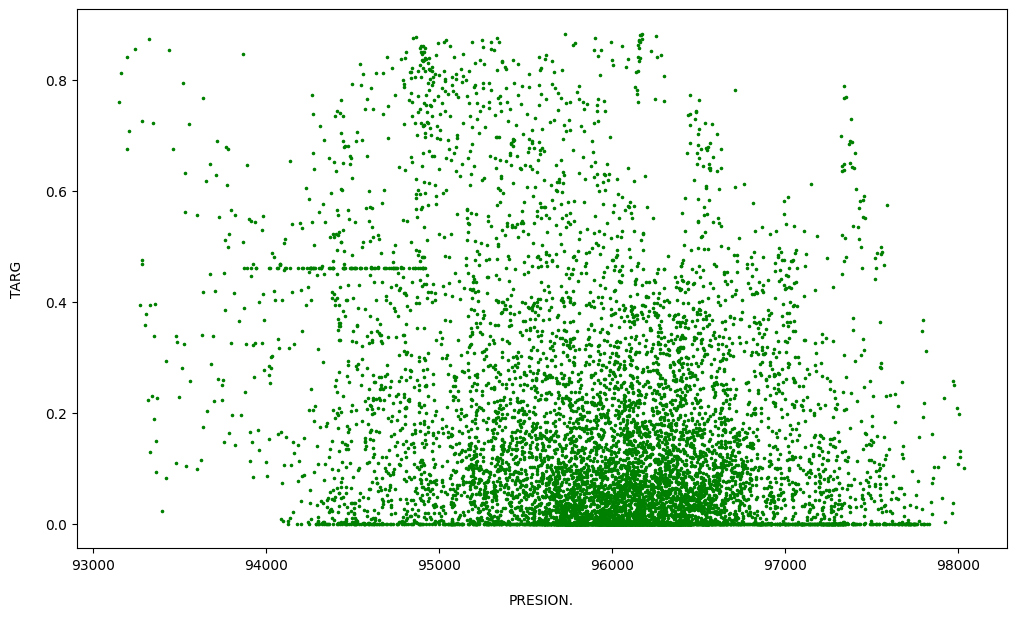

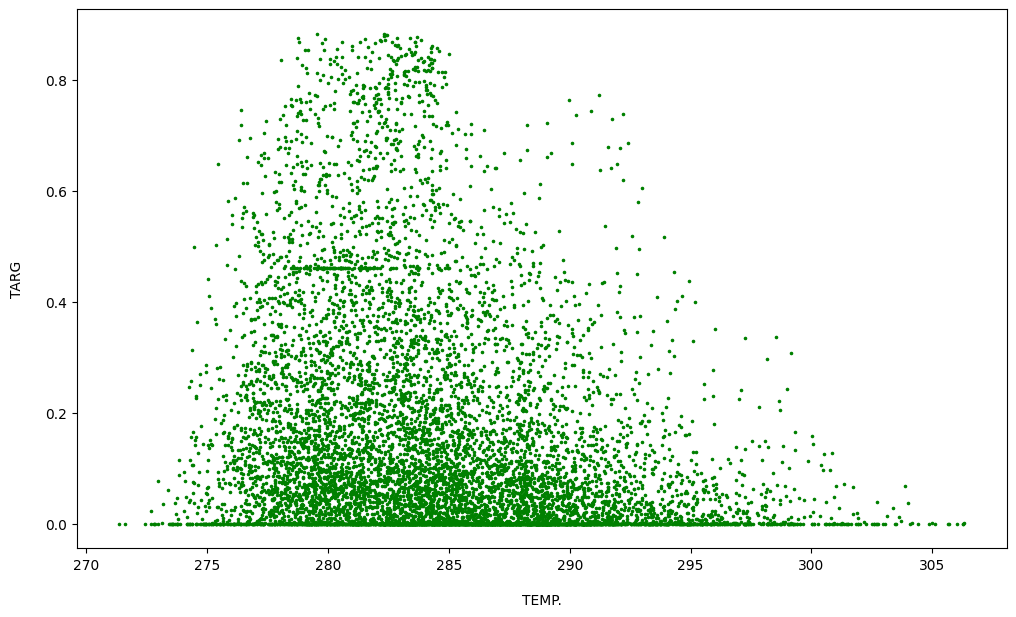

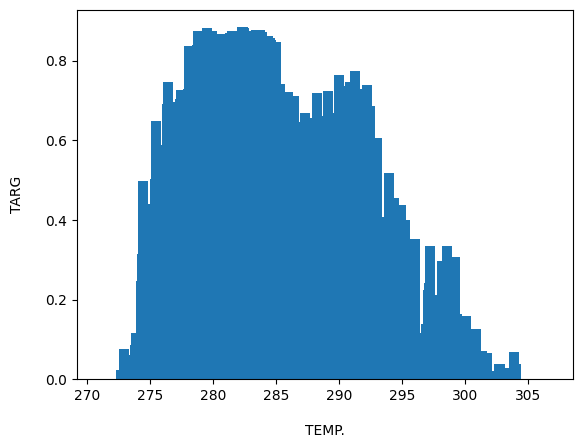

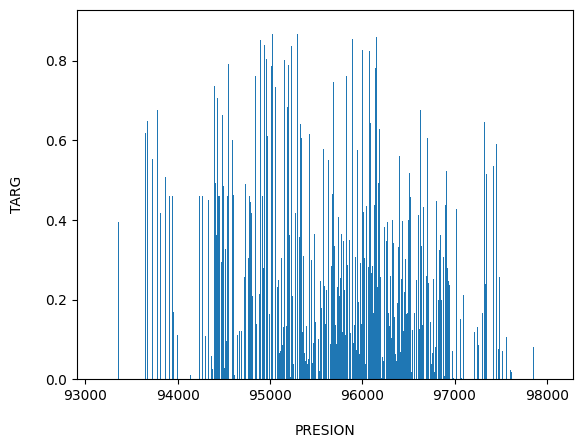

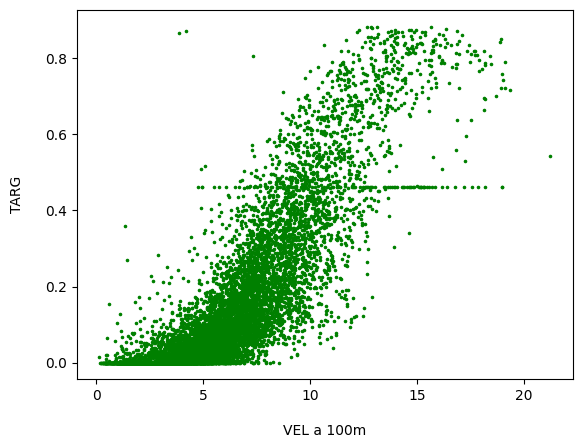

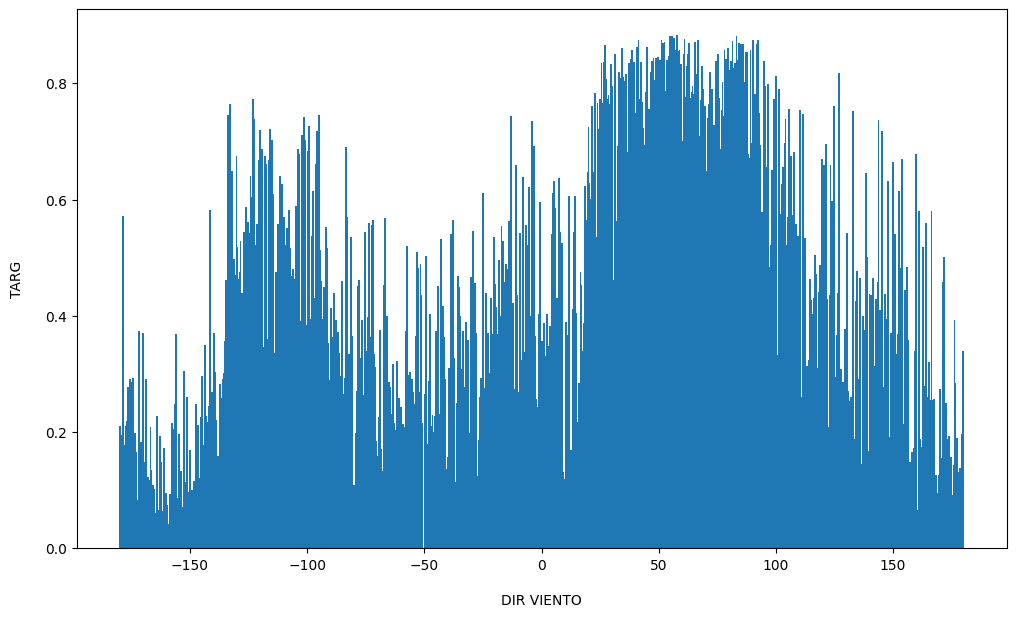

In [52]:
plt.figure(figsize =(12, 7))
plt.xlabel("VELOCIDAD VIENTO A 100m ALT.", labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.scatter(df16['vel100_3'], df16['targ'], c= "green", marker = ".", s=10)

plt.show()

plt.figure(figsize =(12, 7))
plt.xlabel("VELOCIDAD VIENTO A 100m ALT.", labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.scatter(df16['vel100'], df16['targ'], c= "green", marker = ".", s=10)

plt.show()

plt.figure(figsize =(12, 7))
plt.xlabel("PRESION.", labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.scatter(df16['sp'], df16['targ'], c= "green", marker = ".", s=10)

plt.show()

plt.figure(figsize =(12, 7))
plt.xlabel("TEMP.", labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.scatter(df16['2t'], df16['targ'], c= "green", marker = ".", s=10)

plt.show()

plt.xlabel("TEMP.",labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.bar(df16['2t'],df16['targ'])
plt.show()

plt.xlabel("PRESION",labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.bar(df16['sp'],df16['targ'])

plt.show()

plt.xlabel("VEL a 100m",labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.scatter(df16['vel100'], df16['targ'], c= "green", marker = ".", s=10)

plt.show()


plt.figure(figsize =(12, 7))
plt.xlabel("DIR VIENTO", labelpad=15)
plt.ylabel("TARG",labelpad=15)
plt.bar(df16['dir_viento'], df16['targ'])

plt.show()




# Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms over the 2016 data

### Descriptive analysis

## Boxplots

Normalize the data so that all boxplots are in a similar scale.

## Histograms and scatterplots

Plot together all histograms and scatter plots.

## Correlations

Plot them as heatmaps and rank them against the target

## Conclusions from the analysis of data

Write them here

# MLPRegressor

For both MLPs and SVRs we are going to use the data of years 2016 and 2027 for hyperparameter selection and the year 2018 data for testing.

To alleviate the grid search hyperparametrization cost, use the 2016 and 2017 data only with **2 folds without shuffling**.

Also
* analyze the grid search results
* test the final best model

# SV Regressor

We will work with Gaussian kernels, so we have to set two hyperparameters, `C, gamma` plus the `epsilon` insensitivity. We have to explore **three** hyperparameters, so search times may increase considerably.  

Again, to alleviate the grid search hyperparametrization cost, use the 2016 and 2017 data only with **2 folds without shuffling**.

Also
* analyze the grid search results
* test the final best model

## MLP vs SVR comparison and conclusions

Compare both best models, discuss your results and write the conclusions you may find relevant.

Also, suggest ideas which may improve your results.